In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

# 사람 이미지 Segmentation

(570, 401, 3)


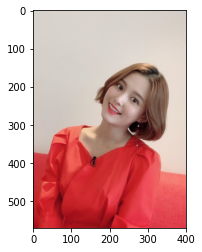

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/rotated_image.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig_human = cv2.imread(img_path) 
print (img_orig_human.shape)
plt.imshow(cv2.cvtColor(img_orig_human, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
plt.show()

## DeepLabModel 함수 선언

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig_human):
        height, width = img_orig_human.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig_human, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

* preprocess --> 전처리
* run --> 실제로 세그멘테이션

* INPUT_SIZE = 513인 이유
![image](https://user-images.githubusercontent.com/68802402/128795971-e38f7cac-9f33-4e41-83bc-b358c5c9b8b9.png)


In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
img_resized, seg_map = MODEL.run(img_orig_human)
print (img_orig_human.shape, img_resized.shape, seg_map.max())

(570, 401, 3) (513, 360, 3) 15


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- seg_map.max() = 15의 의미
    - LABEL_NAMES의 15번 인덱스는 person. -->  person으로 인식했다는 의미

## img_mask, color_mask 생성

seg_map 형태 : (513, 360)
img_mask 형태 : (513, 360)
color_mask 형태 : (513, 360, 3)


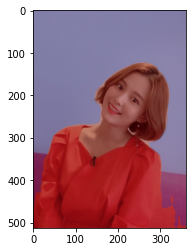

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

print("seg_map 형태 : ",seg_map.shape ,"\n","img_mask 형태 : ",img_mask.shape, "\n","color_mask 형태 : ",color_mask.shape ,  sep="")

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- seg_map = np.where(seg_map == 15, 15, 0)
    - 사람을 뜻하는 15 외 예측은 0으로 만듦

(570, 401)


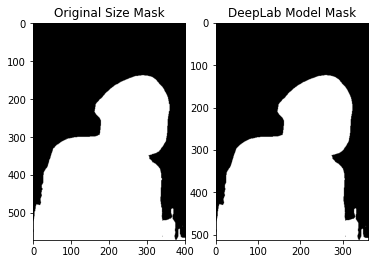

In [8]:
import matplotlib.cm as cm
img_mask_up = cv2.resize(img_mask, img_orig_human.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
print(img_mask_up.shape)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

##### cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    - 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정합니다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.

##### plt.cm.binary_r 의미
![image](https://user-images.githubusercontent.com/68802402/128798089-0020886c-f30b-4718-94ea-0acc7d9e70fb.png)
- + "_r" 은 colormap의 뱐대방향(reverse)를 의미

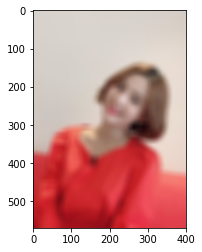

In [9]:
img_orig_blur = cv2.blur(img_orig_human, (20,20)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

- kernel size를 키우면 모자이크가 더 강하게 들어감

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
(570, 401) 

(570, 401, 3)


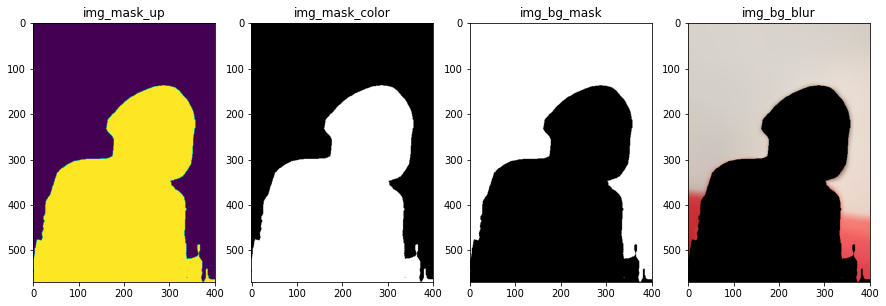

In [10]:
plt.figure(figsize = (15,15))
ax = plt.subplot(1,4,1)
plt.imshow(img_mask_up)
ax.set_title('img_mask_up')
print(img_mask_up)
print(img_mask_up.shape,"\n")



ax = plt.subplot(1,4,2)
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
plt.imshow(img_mask_color)
ax.set_title('img_mask_color')
print(img_mask_color.shape)

ax = plt.subplot(1,4,3)
img_bg_mask = cv2.bitwise_not(img_mask_color)
plt.imshow(img_bg_mask)
ax.set_title('img_bg_mask')


ax = plt.subplot(1,4,4)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
ax.set_title('img_bg_blur')

plt.show()

* img_mask_up의 shape는 (570, 401)이다.
    - 이는 흑백 이미지를 의미하는 것은 아니다. 
    - Segmentation과정에서 person으로 인식하면서 True와 False로 값을 나누는데, GrayScale에서 True, False는 보라색과 노란색으로 표현해주기 때문에 위와같이 표현된 것이다.
    - 0과 255로만 구성된 img_mask_up을 GRAY2BGR 함수로 BGR 이미지로 바꿔주면 당연히 흑백 사진으로 나온다.(RGB로 바꿔도 무방)
    - 결과적으로 img_mask_color 이미지가 Color상태이다.


## 이미지 합성 blur_image + human_image

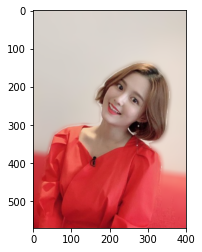

In [11]:
img_concat = np.where(img_mask_color==255, img_orig_human, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

--------------------------------------

--------------------------------------

--------------------------------------

--------------------------------------

#  Cat image

(563, 563, 3)


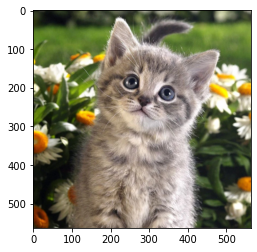

In [12]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_image.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig_cat = cv2.imread(img_path) 
print (img_orig_cat.shape)
plt.imshow(cv2.cvtColor(img_orig_cat, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
plt.show()

## DeepLabModel 함수 선언

In [13]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig_cat):
        height, width = img_orig_cat.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig_cat, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [14]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [15]:
img_resized, seg_map = MODEL.run(img_orig_cat)
print (img_orig_cat.shape, img_resized.shape, seg_map.max())

(563, 563, 3) (513, 513, 3) 8


In [16]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- seg_map.max() = 8의 의미
    - LABEL_NAMES의 8번 인덱스는 cat. -->  cat 인식했다는 의미

## img_mask, color_mask 생성

seg_map 형태 : (513, 513)
img_mask 형태 : (513, 513)
color_mask 형태 : (513, 513, 3)


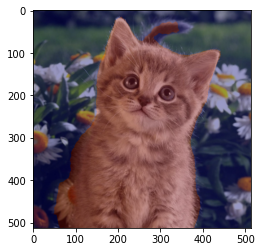

In [17]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == seg_map.max(),seg_map.max(), 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

print("seg_map 형태 : ",seg_map.shape ,"\n","img_mask 형태 : ",img_mask.shape, "\n","color_mask 형태 : ",color_mask.shape ,  sep="")

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

(563, 563)


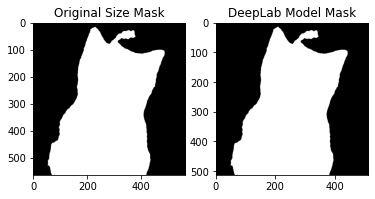

In [18]:
import matplotlib.cm as cm
img_mask_up = cv2.resize(img_mask, img_orig_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
print(img_mask_up.shape)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

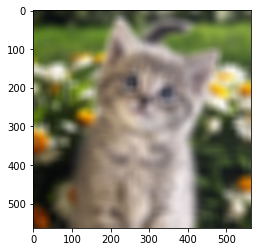

In [19]:
img_orig_blur_cat = cv2.blur(img_orig_cat, (25,25)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(563, 563) 

(563, 563, 3)


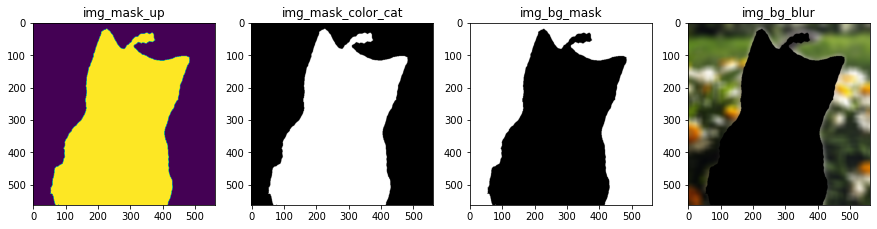

In [20]:
plt.figure(figsize = (15,15))
ax = plt.subplot(1,4,1)
plt.imshow(img_mask_up)
ax.set_title('img_mask_up')
print(img_mask_up)
print(img_mask_up.shape,"\n")



ax = plt.subplot(1,4,2)
img_mask_color_cat = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
plt.imshow(img_mask_color_cat)
ax.set_title('img_mask_color_cat')
print(img_mask_color_cat.shape)

ax = plt.subplot(1,4,3)
img_bg_mask = cv2.bitwise_not(img_mask_color_cat)
plt.imshow(img_bg_mask)
ax.set_title('img_bg_mask')


ax = plt.subplot(1,4,4)
img_bg_blur = cv2.bitwise_and(img_orig_blur_cat, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
ax.set_title('img_bg_blur')

plt.show()

## 이미지 합성 blur_image + human_image

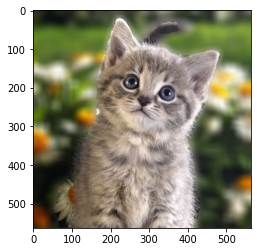

In [21]:
img_concat = np.where(img_mask_color_cat==255, img_orig_cat, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

--------------------------------------

--------------------------------------

--------------------------------------

# Chroma_Key image 
## Color Detection 방식을 사용하여 합성해야 깔끔하게 Segmentation 가능

(639, 1164, 3)


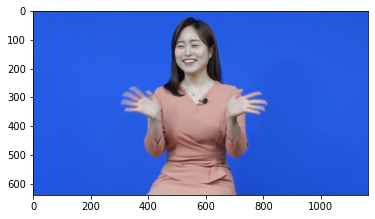

In [22]:
import os

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Chroma_Key_image.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig_ChromaKey = cv2.imread(img_path) 
print (img_orig_ChromaKey.shape)
plt.imshow(cv2.cvtColor(img_orig_ChromaKey, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
plt.show()

In [23]:
hsv = cv2.cvtColor(img_orig_ChromaKey, cv2.COLOR_BGR2HSV)

In [24]:
# define range of blue color in HSV
lower_blue = np.array([100,100,100])
upper_blue = np.array([130,255,255])

In [25]:
mask = cv2.inRange(hsv, lower_blue, upper_blue)

In [26]:
res = cv2.bitwise_and(img_orig_ChromaKey,img_orig_ChromaKey, mask= mask)

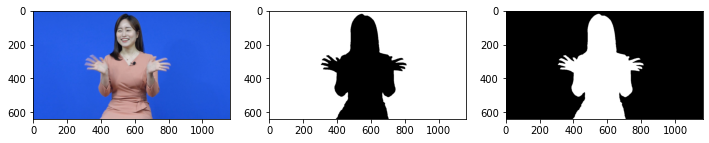

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(cv2.cvtColor(img_orig_ChromaKey, cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.subplot(133)
plt.imshow(cv2.bitwise_not(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)))

# 3번째 사진을 mask로 저장
real_mask = cv2.bitwise_not(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

plt.show()

(746, 1380, 3)


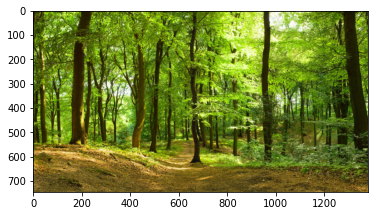

(639, 1164, 3)

In [28]:
forest_img = cv2.imread(os.getenv('HOME')+'/aiffel/human_segmentation/images/forest.png')
plt.imshow(cv2.cvtColor(forest_img, cv2.COLOR_BGR2RGB))
print(forest_img.shape)
plt.show()
forest_img = cv2.resize(forest_img, dsize=(img_orig_ChromaKey.shape[1], img_orig_ChromaKey.shape[0]), interpolation=cv2.INTER_CUBIC)
forest_img.shape


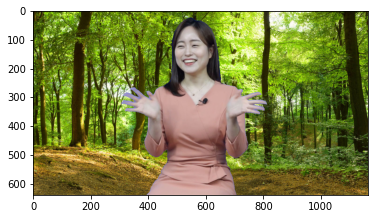

In [29]:
img_concat = np.where(real_mask==255, img_orig_ChromaKey, forest_img)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* 잘 된 사례

## 잘못된 예 - Segmentation 함수를 사용할 경우 누끼 제대로 안따짐

## DeepLabModel 함수 선언

In [30]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig_ChromaKey):
        height, width = img_orig_ChromaKey.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig_ChromaKey, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [31]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [32]:
img_resized, seg_map = MODEL.run(img_orig_ChromaKey)
print (img_orig_ChromaKey.shape, img_resized.shape, seg_map.max())

(639, 1164, 3) (281, 513, 3) 15


In [33]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

## img_mask, color_mask 생성

seg_map 형태 : (281, 513)
img_mask 형태 : (281, 513)
color_mask 형태 : (281, 513, 3)


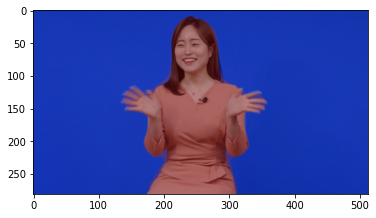

In [34]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == seg_map.max(),seg_map.max(), 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

print("seg_map 형태 : ",seg_map.shape ,"\n","img_mask 형태 : ",img_mask.shape, "\n","color_mask 형태 : ",color_mask.shape ,  sep="")

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

(639, 1164)


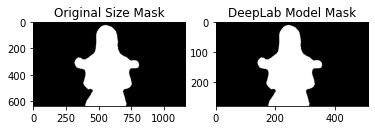

In [35]:
import matplotlib.cm as cm
img_mask_up = cv2.resize(img_mask, img_orig_ChromaKey.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
print(img_mask_up.shape)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

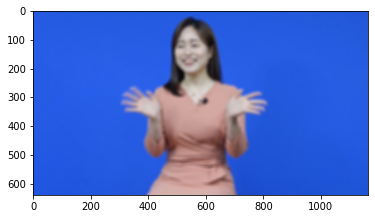

In [36]:
img_orig_blur_ChromaKey = cv2.blur(img_orig_ChromaKey, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur_ChromaKey, cv2.COLOR_BGR2RGB))
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(639, 1164) 

(639, 1164, 3)


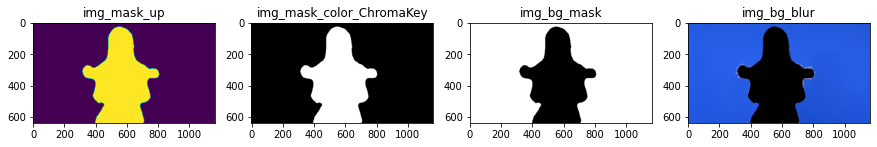

In [37]:
plt.figure(figsize = (15,15))
ax = plt.subplot(1,4,1)
plt.imshow(img_mask_up)
ax.set_title('img_mask_up')
print(img_mask_up)
print(img_mask_up.shape,"\n")



ax = plt.subplot(1,4,2)
img_mask_color_ChromaKey = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
plt.imshow(img_mask_color_ChromaKey)
ax.set_title('img_mask_color_ChromaKey')
print(img_mask_color_ChromaKey.shape)

ax = plt.subplot(1,4,3)
img_bg_mask = cv2.bitwise_not(img_mask_color_ChromaKey)
plt.imshow(img_bg_mask)
ax.set_title('img_bg_mask')


ax = plt.subplot(1,4,4)
img_bg_blur = cv2.bitwise_and(img_orig_blur_ChromaKey, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
ax.set_title('img_bg_blur')

plt.show()

## 이미지 합성 blur_image + human_image

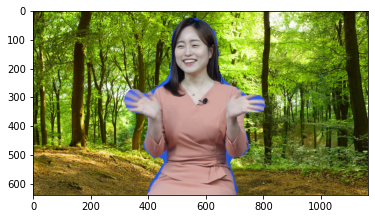

In [38]:
img_concat = np.where(img_mask_color_ChromaKey==255, img_orig_ChromaKey, forest_img)
mix_image_ChromaKey = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

plt.show()

* 잘못 된 사례
    - 사람을 15로 인식하면서 사람으로 인식되는 부분을 모두 15로 바꾼다. 
    - 바꾸는 과정에서 사람에 대한 edge를 아주 정확하게는 알 수 없기 때문에 rough하게 잡는 것 같다.

--------------------------------------

# 저화질 크로마키 사진 실험

## DeepLabModel 함수 선언

(639, 1164, 3)


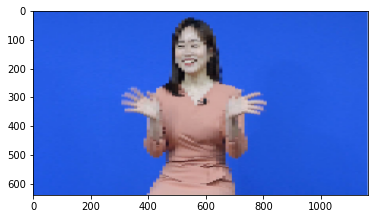

In [39]:
import os

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Chroma_Key_image_low_visual.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig_ChromaKey = cv2.imread(img_path) 
print (img_orig_ChromaKey.shape)
plt.imshow(cv2.cvtColor(img_orig_ChromaKey, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
plt.show()

In [40]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig_ChromaKey):
        height, width = img_orig_ChromaKey.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig_ChromaKey, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [41]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [42]:
img_resized, seg_map = MODEL.run(img_orig_ChromaKey)
print (img_orig_ChromaKey.shape, img_resized.shape, seg_map.max())

(639, 1164, 3) (281, 513, 3) 15


In [43]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

## img_mask, color_mask 생성

seg_map 형태 : (281, 513)
img_mask 형태 : (281, 513)
color_mask 형태 : (281, 513, 3)


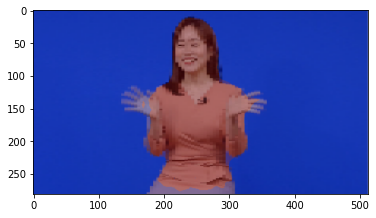

In [44]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == seg_map.max(),seg_map.max(), 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

print("seg_map 형태 : ",seg_map.shape ,"\n","img_mask 형태 : ",img_mask.shape, "\n","color_mask 형태 : ",color_mask.shape ,  sep="")

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- seg_map = np.where(seg_map == 15, 15, 0)
    - 사람을 뜻하는 15 외 예측은 0으로 만듦

(639, 1164)


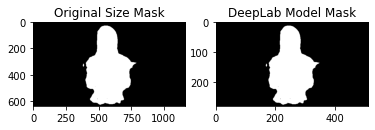

In [45]:
import matplotlib.cm as cm
img_mask_up = cv2.resize(img_mask, img_orig_ChromaKey.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
print(img_mask_up.shape)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

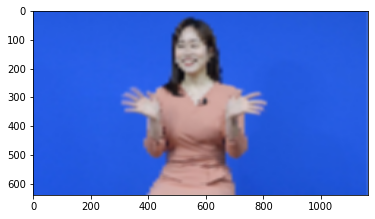

In [46]:
img_orig_blur_ChromaKey = cv2.blur(img_orig_ChromaKey, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur_ChromaKey, cv2.COLOR_BGR2RGB))
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(639, 1164) 

(639, 1164, 3)


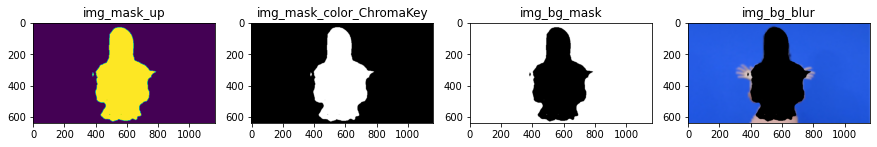

In [47]:
plt.figure(figsize = (15,15))
ax = plt.subplot(1,4,1)
plt.imshow(img_mask_up)
ax.set_title('img_mask_up')
print(img_mask_up)
print(img_mask_up.shape,"\n")



ax = plt.subplot(1,4,2)
img_mask_color_ChromaKey = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
plt.imshow(img_mask_color_ChromaKey)
ax.set_title('img_mask_color_ChromaKey')
print(img_mask_color_ChromaKey.shape)

ax = plt.subplot(1,4,3)
img_bg_mask = cv2.bitwise_not(img_mask_color_ChromaKey)
plt.imshow(img_bg_mask)
ax.set_title('img_bg_mask')


ax = plt.subplot(1,4,4)
img_bg_blur = cv2.bitwise_and(img_orig_blur_ChromaKey, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
ax.set_title('img_bg_blur')

plt.show()

## 이미지 합성 blur_image + human_image

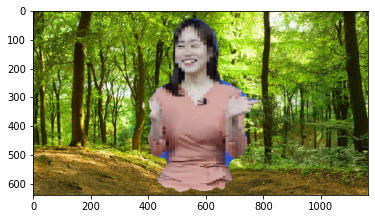

In [48]:
img_concat = np.where(img_mask_color_ChromaKey==255, img_orig_ChromaKey, forest_img)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* 잘못 된 사례(저화질)
    - 저화질 원본사진을 보면 인간은 사람의 Edge를 정확히 구분할 수 있지만 DeepLabModel은 아닌 듯 하다.

-----------------------------------

--------------------------------------

--------------------------------------

# 고양이 축소 후 배경에 합성

## 고양이 축소

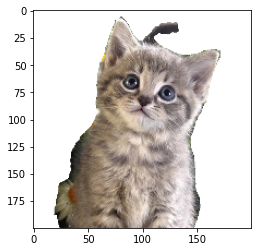

In [49]:
only_cat = np.where(img_mask_color_cat==255, img_orig_cat, 255)
only_cat = cv2.resize(only_cat, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(only_cat, cv2.COLOR_BGR2RGB))
plt.show()

* 합성을 위한 축소버전 고양이 생성 
    - (200,200) 사이즈로 축소하기로 결정 --> 그게 귀여움

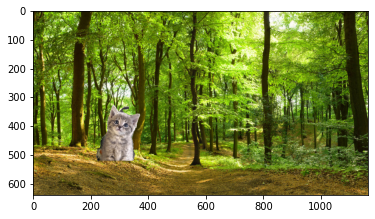

In [50]:
refined_y = 320
refined_x = 200

sticker_area = forest_img[refined_y:refined_y+only_cat.shape[0], refined_x:refined_x+only_cat.shape[1]]
forest_img[refined_y:refined_y+only_cat.shape[0], refined_x:refined_x+only_cat.shape[1]] = np.where(only_cat==255,sticker_area,only_cat).astype(np.uint8)
plt.imshow(cv2.cvtColor(forest_img, cv2.COLOR_BGR2RGB))
plt.show()

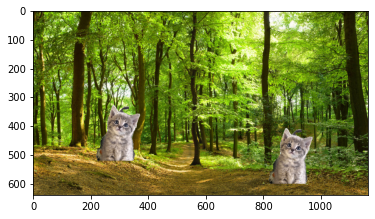

In [51]:
# 귀여우니까 한마리 더 추가하기
refined_y = 400
refined_x = 800

sticker_area = forest_img[refined_y:refined_y+only_cat.shape[0], refined_x:refined_x+only_cat.shape[1]]
forest_img[refined_y:refined_y+only_cat.shape[0], refined_x:refined_x+only_cat.shape[1]] = np.where(only_cat==255,sticker_area,only_cat).astype(np.uint8)
plt.imshow(cv2.cvtColor(forest_img, cv2.COLOR_BGR2RGB))
plt.show()

* 결과
    - 짱귀엽다